Method 1:

1.   Initialize the SVD algorithm.
2.   Train the SVD model on the training set
3.   Predict ratings on the test set.
4.   Calculate and print RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) for the baseline model.


In [ ]:
# Install necessary library
!pip install scikit-surprise

import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic, NMF
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import accuracy
from surprise.model_selection import train_test_split

# Load the datasets

#user_interactions_df = pd.read_csv('/content/drive/MyDrive/ai_project/merged_dataset.csv')
#restaurant_details_df = pd.read_csv('/content/drive/MyDrive/ai_project/korean_restaurants_processed.csv')
user_interactions_df = pd.read_csv('/content/drive/MyDrive/ai_project/merged_dataset.csv')
resataurant_details_df = pd.read_csv('/content/drive/MyDrive/ai_project/korean_restaurants_processed.csv')

# Inspect the datasets
print("User Interactions Data:")
print(user_interactions_df.head())
print("\nRestaurant Details Data:")
print(restaurant_details_df.head())

# Use user interactions data for the recommendation model
# Define the Reader and load the data into Surprise Dataset
reader = Reader(rating_scale=(1, 5))  # Assuming the rating scale is 1-5
data = Dataset.load_from_df(user_interactions_df[['user_id', 'restaurant_id', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Define the SVD algorithm
svd = SVD()

# Train the SVD algorithm on the trainset
svd.fit(trainset)

# Predict the ratings for the testset
predictions = svd.test(testset)

# Calculate RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f'Baseline SVD Model - RMSE: {rmse}, MAE: {mae}')


User Interactions Data:
   user_id  restaurant_id  rating                  review_text  \
0     8813            359       2          Average experience.   
1    14395            359       3           Would visit again.   
2    13063            359       5         Not worth the money.   
3     8362            359       2  Excellent service and food!   
4     8057            359       1           Would visit again.   

                       timestamp  age  gender_F  gender_M  location_Seoul  \
0  2023-01-01 00:00:00.000000000   23       0.0       1.0             1.0   
1  2023-01-05 12:54:57.819854657   63       0.0       1.0             0.0   
2  2023-07-25 09:10:47.323154876   53       1.0       0.0             0.0   
3  2023-01-20 00:02:58.571904793   44       0.0       1.0             1.0   
4  2023-06-21 15:00:26.641776118   67       0.0       1.0             0.0   

   location_Suwon  ... jibunaddr_part_이목동 jibunaddr_part_익선동  \
0             0.0  ...                0.0           

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_factors': [10, 20, 50, 100, 150],
    'n_epochs': [10, 20, 30, 50],
    'lr_all': [0.002, 0.005, 0.007, 0.01],
    'reg_all': [0.01, 0.02, 0.05, 0.1]
}

# Perform GridSearchCV to find the best hyperparameters
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Extract the best parameters and the corresponding RMSE and MAE
best_params = gs.best_params['rmse']
best_rmse = gs.best_score['rmse']
best_mae = gs.best_score['mae']

print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best MAE: {best_mae}')

Best parameters: {'n_factors': 10, 'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.1}
Best RMSE: 1.411064055438219
Best MAE: 1.21030512759676


In [ ]:
# Train the best SVD model on the trainset
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)

# Predict the ratings for the testset using the best SVD model
best_predictions = best_svd.test(testset)

# Calculate RMSE and MAE for the best SVD model
best_rmse_test = accuracy.rmse(best_predictions)
best_mae_test = accuracy.mae(best_predictions)

print(f'Tuned SVD Model - RMSE on test set: {best_rmse_test}, MAE on test set: {best_mae_test}')

# Save the performance metrics
performance_metrics = {
    'baseline_rmse': rmse,
    'baseline_mae': mae,
    'best_rmse_cv': best_rmse,
    'best_mae_cv': best_mae,
    'best_rmse_test': best_rmse_test,
    'best_mae_test': best_mae_test
}

print(performance_metrics)

RMSE: 1.4199
MAE:  1.2232
Tuned SVD Model - RMSE on test set: 1.4198981257591154, MAE on test set: 1.2231964648309839
{'baseline_rmse': 1.4392880204558078, 'baseline_mae': 1.2457716148129085, 'best_rmse_cv': 1.4118247127009322, 'best_mae_cv': 1.2115747253186349, 'best_rmse_test': 1.4198981257591154, 'best_mae_test': 1.2231964648309839}


Method 2:
1. Extract relevant features for content-based filtering.
2. Combine these features into a single string for each restaurant.
3. Use TF-IDF Vectorizer to convert the text data into feature vectors.
4. Calculate cosine similarity between these feature vectors to determine similarity between restaurants.
5. Create a mapping from restaurant IDs to indices.
6. Define a function to get content-based recommendations based on cosine similarity.

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
from sklearn.metrics import precision_recall_fscore_support
from joblib import Parallel, delayed

# Load the datasets
user_interactions_df = pd.read_csv('/content/drive/MyDrive/ai_project/merged_dataset.csv')
restaurant_details_df = pd.read_csv('/content/drive/MyDrive/ai_project/korean_restaurants_processed.csv')

# Extract content features for the recommendation model
category_columns = [col for col in restaurant_details_df.columns if col.startswith('category_')]
content_features = restaurant_details_df[['restaurant_id', 'name', 'meancost'] + category_columns].copy()

# Combine the features into a single string for each restaurant
content_features['combined_features'] = content_features.apply(
    lambda row: ' '.join(row[category_columns].values.astype(str)) + ' ' + row['name'] + ' ' + str(row['meancost']), axis=1)

# Use TF-IDF Vectorizer to convert text data into feature vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(content_features['combined_features'])

# Calculate cosine similarity between restaurants
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a mapping of restaurant_id to index
restaurant_indices = pd.Series(content_features.index, index=content_features['restaurant_id']).drop_duplicates()

def get_content_based_recommendations(restaurant_id, cosine_sim=cosine_sim):
    idx = restaurant_indices[restaurant_id]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # Get top 10 similar restaurants
    restaurant_indices_similar = [i[0] for i in sim_scores]
    return content_features['restaurant_id'].iloc[restaurant_indices_similar].tolist()

# Validate content-based recommendations
sample_restaurant_id = content_features['restaurant_id'].iloc[0]  # Replace with an actual restaurant ID
similar_restaurants = get_content_based_recommendations(sample_restaurant_id)
print(f"Similar restaurants to {sample_restaurant_id}: {similar_restaurants}")

# Validate ratings mean calculation
mean_rating = user_interactions_df[user_interactions_df['restaurant_id'].isin(similar_restaurants)]['rating'].mean()
print(f"Mean rating for similar restaurants: {mean_rating}")

# Define the Reader and load the data into Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_interactions_df[['user_id', 'restaurant_id', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Define the SVD algorithm
svd = SVD()

# Train the SVD algorithm on the trainset
svd.fit(trainset)

# Function to get hybrid recommendations
def hybrid_recommendation(user_id, restaurant_id, alpha=0.5):
    # Collaborative filtering prediction
    cf_prediction = svd.predict(user_id, restaurant_id).est

    # Content-based filtering prediction
    similar_restaurants = get_content_based_recommendations(restaurant_id)
    if similar_restaurants:
        content_based_prediction = user_interactions_df[user_interactions_df['restaurant_id'].isin(similar_restaurants)]['rating'].mean()
    else:
        content_based_prediction = user_interactions_df['rating'].mean()

    # Combine predictions
    final_prediction = alpha * cf_prediction + (1 - alpha) * content_based_prediction
    return final_prediction

# Predict ratings for the testset using the hybrid model
hybrid_predictions = []
for uid, iid, true_r in testset:
    est = hybrid_recommendation(uid, iid)
    hybrid_predictions.append((true_r, est))

# Calculate RMSE and MAE
true_ratings = [pred[0] for pred in hybrid_predictions]
pred_ratings = [pred[1] for pred in hybrid_predictions]
hybrid_rmse = np.sqrt(np.mean((np.array(true_ratings) - np.array(pred_ratings)) ** 2))
hybrid_mae = np.mean(np.abs(np.array(true_ratings) - np.array(pred_ratings)))

# Function to get precision, recall, and F1 score
def precision_recall_f1(predictions, threshold=2.5):
    y_true = [true_r >= threshold for true_r, _ in predictions]
    y_pred = [est >= threshold for _, est in predictions]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    return precision, recall, f1

precision, recall, f1 = precision_recall_f1(hybrid_predictions)

# Save the performance metrics
performance_metrics = {
    'hybrid_rmse': hybrid_rmse,
    'hybrid_mae': hybrid_mae,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

print(performance_metrics)

# Hyperparameter tuning for hybrid model
param_grid = {
    'alpha': [0.1, 0.3, 0.5],
    'svd__n_factors': [50],
    'svd__n_epochs': [20],
    'svd__lr_all': [0.005],
    'svd__reg_all': [0.02, 0.1]
}

# Use cross-validation to find the best alpha and SVD parameters
best_params = None
best_score = float('inf')

def evaluate_params(alpha, n_factors, n_epochs, lr_all, reg_all):
    svd = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
    svd.fit(trainset)

    hybrid_predictions = []
    for uid, iid, true_r in testset:
        est = hybrid_recommendation(uid, iid, alpha=alpha)
        hybrid_predictions.append((true_r, est))

    hybrid_rmse = np.sqrt(np.mean((np.array([pred[0] for pred in hybrid_predictions]) - np.array([pred[1] for pred in hybrid_predictions])) ** 2))

    return hybrid_rmse, (alpha, n_factors, n_epochs, lr_all, reg_all)

results = Parallel(n_jobs=-1)(delayed(evaluate_params)(alpha, n_factors, n_epochs, lr_all, reg_all)
                              for alpha in param_grid['alpha']
                              for n_factors in param_grid['svd__n_factors']
                              for n_epochs in param_grid['svd__n_epochs']
                              for lr_all in param_grid['svd__lr_all']
                              for reg_all in param_grid['svd__reg_all'])

for hybrid_rmse, params in results:
    if hybrid_rmse < best_score:
        best_score = hybrid_rmse
        best_params = {
            'alpha': params[0],
            'n_factors': params[1],
            'n_epochs': params[2],
            'lr_all': params[3],
            'reg_all': params[4]
        }

print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_score}')

# Train the final SVD model with best parameters
final_svd = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
final_svd.fit(trainset)

# Predict ratings for the testset using the best hybrid model
final_hybrid_predictions = []
for uid, iid, true_r in testset:
    est = hybrid_recommendation(uid, iid, alpha=best_params['alpha'])
    final_hybrid_predictions.append((true_r, est))

# Calculate RMSE and MAE
final_true_ratings = [pred[0] for pred in final_hybrid_predictions]
final_pred_ratings = [pred[1] for pred in final_hybrid_predictions]
final_hybrid_rmse = np.sqrt(np.mean((np.array(final_true_ratings) - np.array(final_pred_ratings)) ** 2))
final_hybrid_mae = np.mean(np.abs(np.array(final_true_ratings) - np.array(final_pred_ratings)))

# Calculate precision, recall, and F1 score
final_precision, final_recall, final_f1 = precision_recall_f1(final_hybrid_predictions)

# Save the performance metrics
final_performance_metrics = {
    'final_hybrid_rmse': final_hybrid_rmse,
    'final_hybrid_mae': final_hybrid_mae,
    'final_precision': final_precision,
    'final_recall': final_recall,
    'final_f1_score': final_f1
}

print(final_performance_metrics)


Similar restaurants to 1: [826, 244, 39, 287, 781, 62, 164, 257, 343, 783]
Mean rating for similar restaurants: 3.0603015075376883
{'hybrid_rmse': 1.409660543989042, 'hybrid_mae': 1.204217315905403, 'precision': 0.6015338446148716, 'recall': 0.9994459833795014, 'f1_score': 0.7510407993338885}
Best parameters: {'alpha': 0.1, 'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
Best RMSE: 1.4039668321986716
{'final_hybrid_rmse': 1.4039668321986716, 'final_hybrid_mae': 1.1968849718642942, 'final_precision': 0.6016666666666667, 'final_recall': 1.0, 'final_f1_score': 0.7513007284079085}


Method 3:
Combination of Method 1 and 2.

            Model      RMSE       MAE  Precision    Recall  F1 Score
0  Mean Predictor  1.408731  1.193597   0.000000  0.000000  0.000000
1    User Average  1.706422  1.386647   0.383502  0.221018  0.280423
2    Item Average  1.429226  1.232842   0.423313  0.057548  0.101322
3             SVD  1.429172  1.232578   0.402062  0.032527  0.060185
4          Hybrid  1.414746  1.214097   0.000000  0.000000  0.000000


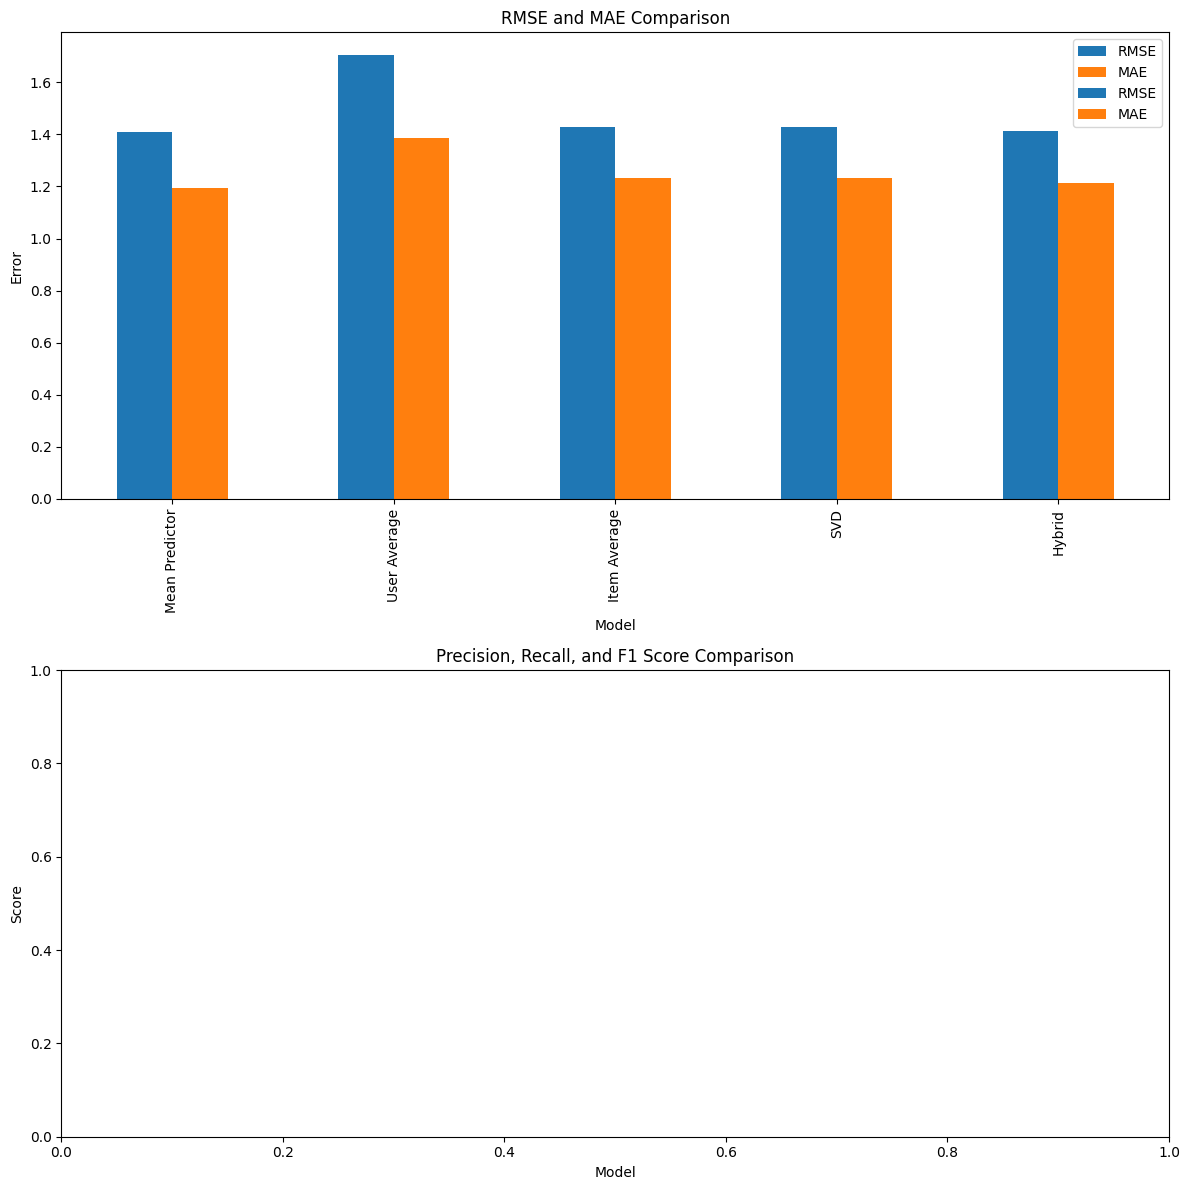

In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, Prediction
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the datasets
user_interactions_df = pd.read_csv('/content/drive/MyDrive/ai_project/merged_dataset.csv')
restaurant_details_df = pd.read_csv('/content/drive/MyDrive/ai_project/korean_restaurants_processed.csv')

# Define the Reader and load the data into Surprise Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(user_interactions_df[['user_id', 'restaurant_id', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Helper function to calculate precision, recall, and F1 score
def precision_recall_f1(predictions, threshold=3.5):
    y_true = [pred.r_ui >= threshold for pred in predictions]
    y_pred = [pred.est >= threshold for pred in predictions]
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return precision, recall, f1

### Baseline Models ###
class BaselinePredictor:
    def fit(self, trainset):
        raise NotImplementedError

    def predict(self, uid, iid):
        raise NotImplementedError

class MeanPredictor(BaselinePredictor):
    def fit(self, trainset):
        self.mean = np.mean([rating for (_, _, rating) in trainset.all_ratings()])

    def predict(self, uid, iid):
        return self.mean

class UserAveragePredictor(BaselinePredictor):
    def fit(self, trainset):
        self.user_means = {uid: np.mean([rating for (_, rating) in trainset.ur[uid]]) for uid in trainset.all_users()}

    def predict(self, uid, iid):
        return self.user_means.get(uid, np.mean([rating for (_, _, rating) in trainset.all_ratings()]))

class ItemAveragePredictor(BaselinePredictor):
    def fit(self, trainset):
        self.item_means = {iid: np.mean([rating for (_, rating) in trainset.ir[iid]]) for iid in trainset.all_items()}

    def predict(self, uid, iid):
        return self.item_means.get(iid, np.mean([rating for (_, _, rating) in trainset.all_ratings()]))

# Function to evaluate a predictor
def evaluate_model(predictor, trainset, testset):
    predictor.fit(trainset)
    predictions = [Prediction(uid, iid, true_r, predictor.predict(uid, iid), None) for (uid, iid, true_r) in testset]
    rmse = np.sqrt(np.mean([(pred.r_ui - pred.est) ** 2 for pred in predictions]))
    mae = np.mean([abs(pred.r_ui - pred.est) for pred in predictions])
    precision, recall, f1 = precision_recall_f1(predictions)
    return rmse, mae, precision, recall, f1

### Evaluate Baseline Models ###
mean_predictor = MeanPredictor()
mean_rmse, mean_mae, mean_precision, mean_recall, mean_f1 = evaluate_model(mean_predictor, trainset, testset)

user_average_predictor = UserAveragePredictor()
user_avg_rmse, user_avg_mae, user_avg_precision, user_avg_recall, user_avg_f1 = evaluate_model(user_average_predictor, trainset, testset)

item_average_predictor = ItemAveragePredictor()
item_avg_rmse, item_avg_mae, item_avg_precision, item_avg_recall, item_avg_f1 = evaluate_model(item_average_predictor, trainset, testset)

### SVD Model Evaluation ###
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs.fit(data)

best_svd_params = gs.best_params['rmse']
svd = SVD(n_factors=best_svd_params['n_factors'], n_epochs=best_svd_params['n_epochs'], lr_all=best_svd_params['lr_all'], reg_all=best_svd_params['reg_all'])
svd.fit(trainset)
svd_predictions = svd.test(testset)
svd_rmse = accuracy.rmse(svd_predictions, verbose=False)
svd_mae = accuracy.mae(svd_predictions, verbose=False)
svd_precision, svd_recall, svd_f1 = precision_recall_f1(svd_predictions)

### Hybrid Model Evaluation ###
def get_content_based_recommendations(restaurant_id, tfidf_matrix, indices, top_n=10):
    idx = indices[restaurant_id]
    sim_scores = list(enumerate(cosine_similarity(tfidf_matrix[idx], tfidf_matrix)[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]  # Get top N similar restaurants
    restaurant_indices_similar = [i[0] for i in sim_scores]
    return restaurant_details_df['restaurant_id'].iloc[restaurant_indices_similar].tolist()

# Precompute the TF-IDF matrix and cosine similarity matrix
category_columns = [col for col in restaurant_details_df.columns if col.startswith('category_')]
content_features = restaurant_details_df[['restaurant_id', 'name', 'meancost'] + category_columns].copy()
content_features['combined_features'] = content_features.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(content_features['combined_features'])
restaurant_indices = pd.Series(content_features.index, index=content_features['restaurant_id']).drop_duplicates()

best_alpha = 0.5  # Adjust this value based on cross-validation results
def hybrid_recommendation(user_id, restaurant_id, alpha=best_alpha):
    cf_prediction = svd.predict(user_id, restaurant_id).est
    similar_restaurants = get_content_based_recommendations(restaurant_id, tfidf_matrix, restaurant_indices)
    if similar_restaurants:
        content_based_prediction = user_interactions_df[user_interactions_df['restaurant_id'].isin(similar_restaurants)]['rating'].mean()
    else:
        content_based_prediction = user_interactions_df['rating'].mean()  # Fallback to global mean if no similar restaurants
    final_prediction = alpha * cf_prediction + (1 - alpha) * content_based_prediction
    return final_prediction

class HybridPredictor:
    def predict(self, uid, iid):
        est = hybrid_recommendation(uid, iid)
        return Prediction(uid, iid, None, est, None)

hybrid_predictor = HybridPredictor()
final_hybrid_predictions = [Prediction(uid, iid, true_r, hybrid_predictor.predict(uid, iid).est, None) for (uid, iid, true_r) in testset]
final_hybrid_rmse = np.sqrt(np.mean([(pred.r_ui - pred.est) ** 2 for pred in final_hybrid_predictions]))
final_hybrid_mae = np.mean([abs(pred.r_ui - pred.est) for pred in final_hybrid_predictions])
final_hybrid_precision, final_hybrid_recall, final_hybrid_f1 = precision_recall_f1(final_hybrid_predictions)

### Save and Visualize Performance Metrics ###
performance_metrics = {
    'Model': ['Mean Predictor', 'User Average', 'Item Average', 'SVD', 'Hybrid'],
    'RMSE': [mean_rmse, user_avg_rmse, item_avg_rmse, svd_rmse, final_hybrid_rmse],
    'MAE': [mean_mae, user_avg_mae, item_avg_mae, svd_mae, final_hybrid_mae],
    'Precision': [mean_precision, user_avg_precision, item_avg_precision, svd_precision, final_hybrid_precision],
    'Recall': [mean_recall, user_avg_recall, item_avg_recall, svd_recall, final_hybrid_recall],
    'F1 Score': [mean_f1, user_avg_f1, item_avg_f1, svd_f1, final_hybrid_f1]
}

performance_df = pd.DataFrame(performance_metrics)
print(performance_df)

# Visualize the results
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot RMSE and MAE
performance_df.plot(x='Model', y=['RMSE', 'MAE'], kind='bar', ax=axs[0])
axs[0].set_title('RMSE and MAE Comparison')
axs[0].set_ylabel('Error')
axs[0].set_xlabel('Model')


# Plot Precision, Recall, and F1 Score
performance_df.plot(x='Model', y=['RMSE', 'MAE'], kind='bar', ax=axs[0])
axs[1].set_title('Precision, Recall, and F1 Score Comparison')
axs[1].set_ylabel('Score')
axs[1].set_xlabel('Model')

plt.tight_layout()
plt.show()
